# 7章 RNNによる文章生成

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *
import pickle
'''
※chapter06からコピー
'''
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [2]:
from common.functions import softmax

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

In [3]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('Rnnlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you 1970s midler annual burst six-month force greenberg polish slid lipton dave settled lens tracks seita tuesday amounted judgment mips abundant client ahead victor troublesome unless degrees schering-plough dai-ichi again garratt passed gambling glamorous upper manage railroad inevitably prevention less-developed della emerges st. judging cautious minpeco annuities restrictive activity exploded interview acquitted leg bernard bogart offset jokes changing facsimile katz olympic assassinations seymour embraced multinational atoms effect carpets masters january disagree mexico khmer victories antibody react solely prepayment ways denies bang refusing alleges warner-lambert etc. capita compliance spun favors hitting investment landmark fronts pesticides folk third prosecutor corners medium-sized workings


In [4]:
'''
※chapter06からコピー
'''
class BetterRnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

    def save_params(self, file_name='BetterRnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='BetterRnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [5]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

In [ ]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterRnnlmGen()
model.load_params('BetterRnnlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

In [ ]:
model = BetterRnnlmGen()
model.load_params('BetterRnnlm.pkl')

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

In [6]:
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


In [12]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [13]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

In [14]:
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
    
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [15]:
import matplotlib.pyplot as plt
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# モデル / オプティマイザ / トレーナーの生成
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
    
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 2[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 3[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 4[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 4[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 5[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 7[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 8[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 8[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 9[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 10[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 10[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 11[s] | loss 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T

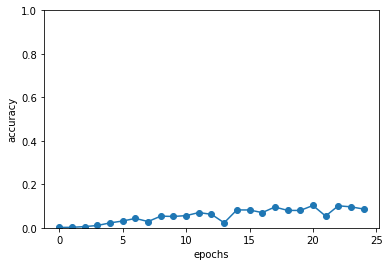

In [16]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

In [17]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# モデル / オプティマイザ / トレーナーの生成
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

racc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, True)
    
    racc = float(correct_num) / len(x_test)
    racc_list.append(racc)
    print('val racc %.3f%%' % (racc * 100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 2[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 2[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 3[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 4[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 4[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 5[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 7[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 7[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 8[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 9[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 9[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 10[s] | loss 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 6

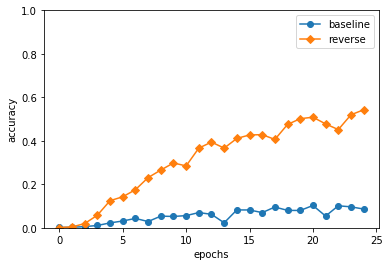

In [22]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o', label='baseline')
plt.plot(x, racc_list, marker='D', label='reverse')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.show()

In [19]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None
    
    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score
    
    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

In [20]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [21]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# モデル / オプティマイザ / トレーナーの生成
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

pacc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, True)
    
    pacc = float(correct_num) / len(x_test)
    pacc_list.append(pacc)
    print('val pacc %.3f%%' % (pacc * 100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.48
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.20
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.99
| epoch 1 |  iter 81 / 351 | time 2[s] | loss 1.89
| epoch 1 |  iter 101 / 351 | time 3[s] | loss 1.82
| epoch 1 |  iter 121 / 351 | time 3[s] | loss 1.82
| epoch 1 |  iter 141 / 351 | time 4[s] | loss 1.80
| epoch 1 |  iter 161 / 351 | time 5[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 5[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 7[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 7[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 8[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 9[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 9[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 10[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 11[s] | loss 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 

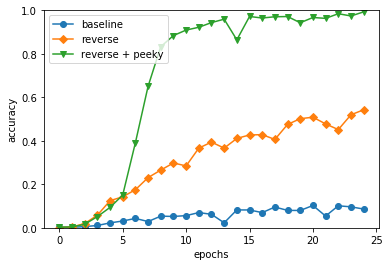

In [23]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o', label='baseline')
plt.plot(x, racc_list, marker='D', label='reverse')
plt.plot(x, pacc_list, marker='v', label='reverse + peeky')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.show()